# Mr. Fries Machine Learning

In [11]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import folium
import imageio
from tqdm import tqdm_notebook
from folium.plugins import MarkerCluster
import imageio
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import scipy
from itertools import product
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

# Connect to Database

In [50]:
import psycopg2
import pandas as pd
import os
from io import StringIO

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

param_dic = {
    "host"      : "cgl-analytics-database.cljzyx4k3eiy.us-east-2.rds.amazonaws.com",
    "database"  : "postgres",
    "user"      : "postgres",
    "password"  : "cglanalytics"
}
db_url = {'drivername': 'postgresql+psycopg2',
        'username': 'postgres',
        'password': 'cglanalytics',
        'host': 'cgl-analytics-database.cljzyx4k3eiy.us-east-2.rds.amazonaws.com',
        'port': 5432,
        'database': 'postgres'
}

def connect(params_dic):
    '''Connect to the PostgreSQL database server''' 
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        print("Connection not successful!")
        sys.exit(1)
    print("Connection Successful!")
    return conn

def execute_query(conn, query):
    """ Execute a single query """
    
    ret = 0 # Return value
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1

    # If this was a select query, return the result
    if 'select' in query.lower():
        ret = cursor.fetchall()
    cursor.close()
    return ret

def open_as_df(query,conn):
    '''pass query to get dataframe: select * from "5_min" '''
    try:
        df = pd.read_sql_query(sql = query,con = conn)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
    conn.close()
    return df

def copy_table_schema(existing_tb, new_tb):
    from sqlalchemy import create_engine, MetaData, Table
    from sqlalchemy.engine.url import URL

    engine = create_engine(URL(**db_url))
    engine._metadata = MetaData(bind=engine)
    engine._metadata.reflect(engine)
    sch_Table = Table(existing_tb, engine._metadata)
    new_Table = Table(new_tb, engine._metadata)

    # copy schema and create newTable from oldTable
    for column in sch_Table.columns:
        new_Table.append_column(column.copy())
    new_Table.create()
    
def copy_to_db(conn, df, table):
    """
    save the dataframe in memory and use copy_from() to copy it to the table in the db
    """
    # save dataframe to an object in memory buffer
    buffer = StringIO()
    df.to_csv(buffer, header=False, index = False)
    buffer.seek(0)
    
    cursor = conn.cursor()
    try:
        cursor.copy_from(buffer, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("Done!")
    cursor.close()
    conn.close()

In [16]:
execute_query(connect(param_dic), 'SELECT datname FROM pg_database;')
data = open_as_df('SELECT * FROM "clean_cities"',connect(param_dic))

Connecting to the PostgreSQL database...
Connection Successful!
Connecting to the PostgreSQL database...
Connection Successful!


In [21]:
data

,id,dt,city,forec,s_forec,averagetemperature


# Create List of Cities

In [8]:
df3 = data[data["averagetemperature_f"] <= 32]
days_below_freezing = df3['city'].value_counts()
top_5_coldest = list(days_below_freezing[0:5].keys())
top_5_coldest

['Harbin', 'Changchun', 'Moscow', 'Montreal', 'Saint Petersburg']

# Change City Name to Create New Output

In [7]:
data.head()

,id,dt,averagetemperature_f,averagetemperatureuncertainty,city,country,latitude,longitude
0,864,1921-01-01,80.0,1.0,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,865,1921-02-01,84.0,1.0,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,866,1921-03-01,82.0,1.0,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,867,1921-04-01,82.0,1.0,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,868,1921-05-01,80.0,0.0,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [8]:
city = "Changchun"

In [9]:
city_data = data[data['city']== city]

In [10]:
city_data.head()

,id,dt,averagetemperature_f,averagetemperatureuncertainty,city,country,latitude,longitude
21150,48243,1921-01-01,7.0,1.0,Changchun,China,44.20N,125.22E
21151,48244,1921-02-01,12.0,1.0,Changchun,China,44.20N,125.22E
21152,48245,1921-03-01,24.0,0.0,Changchun,China,44.20N,125.22E
21153,48246,1921-04-01,44.0,1.0,Changchun,China,44.20N,125.22E
21154,48247,1921-05-01,59.0,0.0,Changchun,China,44.20N,125.22E


# Create Year Month day and weekday columns to fit machine learning models

In [11]:
city_data = city_data.reset_index()

In [12]:
city_data = city_data.drop(columns=['index'])

In [13]:
city_data.dt = pd.to_datetime(city_data.dt)

In [14]:
YEAR = []
MONTH = []
DAY = []
WEEKDAY = []
for i in range(len(city_data)):
    WEEKDAY.append(city_data.dt[i].weekday())
    DAY.append(city_data.dt[i].day)
    MONTH.append(city_data.dt[i].month)
    YEAR.append(city_data.dt[i].year)

In [15]:
city_data['Year'] = YEAR
city_data['Month'] = MONTH
city_data['Day'] = DAY 
city_data['Weekday'] = WEEKDAY

In [16]:
change_year_index = []
change_year = []
year_list = city_data['Year'].tolist()
for y in range(0,len(year_list)-1):
    if year_list[y]!=year_list[y+1]:
        change_year.append(year_list[y+1])
        change_year_index.append(y+1)

In [17]:
city_data.loc[change_year_index].head()
city_data

,id,dt,averagetemperature_f,averagetemperatureuncertainty,city,country,latitude,longitude,Year,Month,Day,Weekday
0,48243,1921-01-01,7.0,1.0,Changchun,China,44.20N,125.22E,1921,1,1,5
1,48244,1921-02-01,12.0,1.0,Changchun,China,44.20N,125.22E,1921,2,1,1
2,48245,1921-03-01,24.0,0.0,Changchun,China,44.20N,125.22E,1921,3,1,1
3,48246,1921-04-01,44.0,1.0,Changchun,China,44.20N,125.22E,1921,4,1,4
4,48247,1921-05-01,59.0,0.0,Changchun,China,44.20N,125.22E,1921,5,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1108,49351,2013-05-01,64.0,0.0,Changchun,China,44.20N,125.22E,2013,5,1,2
1109,49352,2013-06-01,71.0,1.0,Changchun,China,44.20N,125.22E,2013,6,1,5
1110,49353,2013-07-01,76.0,0.0,Changchun,China,44.20N,125.22E,2013,7,1,0
1111,49354,2013-08-01,74.0,0.0,Changchun,China,44.20N,125.22E,2013,8,1,3


In [18]:
x_ticks_year_list=np.linspace(min(year_list),max(year_list),10).astype(int)
change_year_index = np.array(change_year_index)
x_ticks_year_index = []
for i in range(1,len(x_ticks_year_list)):
    x_ticks_year_index.append(change_year_index[np.where(np.array(change_year)==x_ticks_year_list[i])][0])

In [19]:
last_year_data = city_data[city_data.Year>=2010].reset_index().drop(columns=['index'])
P = np.linspace(0,len(last_year_data)-1,5).astype(int)

In [20]:
def get_timeseries(start_year,end_year):
    last_year_data = city_data[(city_data.Year>=start_year) & (city_data.Year<=end_year)].reset_index().drop(columns=['index'])
    return last_year_data

In [29]:
def plot_timeseries(start_year,end_year):
    last_year_data = get_timeseries(start_year,end_year)
    P = np.linspace(0,len(last_year_data)-1,5).astype(int)
    plt.plot(last_year_data.averagetemperature_f,marker='.',color='firebrick')
    plt.xticks(np.arange(0,len(last_year_data),1)[P],last_year_data.dt.loc[P],rotation=60)
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

In [22]:
def plot_from_data(data,time,c='firebrick',with_ticks=True,label=None):
    time = time.tolist()
    data = np.array(data.tolist())
    P = np.linspace(0,len(data)-1,5).astype(int)
    time = np.array(time)
    if label==None:
        plt.plot(data,marker='.',color=c)
    else:
        plt.plot(data,marker='.',color=c,label=label)
    if with_ticks==True:
        plt.xticks(np.arange(0,len(data),1)[P],time[P],rotation=60)
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


(2.0, 22.0)

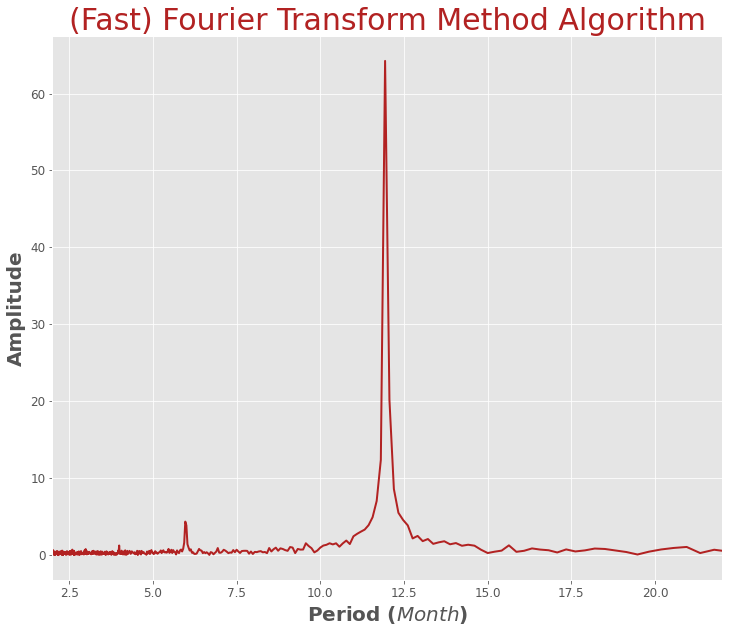

In [24]:
FFT = np.fft.fft(city_data.averagetemperature_f)
FFT_abs = np.abs(FFT)
new_N=int(len(FFT)/2) 
f_nat=1
new_X = np.linspace(0, f_nat/2, new_N, endpoint=True)
new_X = 1/new_X
plt.plot(new_X,2*FFT_abs[0:int(len(FFT)/2.)]/len(new_X),color='firebrick')
plt.xlabel('Period ($Month$)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=30,color='firebrick')
plt.grid(True)
plt.xlim(2,22)

# Checking on Stationarity

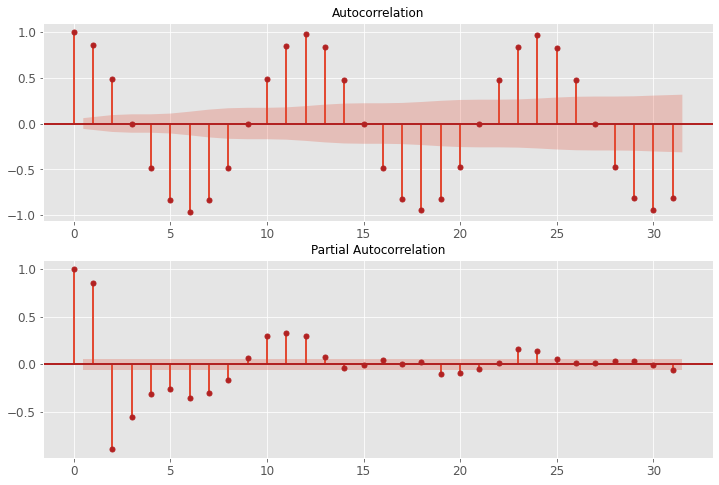

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(city_data.averagetemperature_f, ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(city_data.averagetemperature_f, ax=ax2,color='firebrick')

In [26]:
result = adfuller(city_data.averagetemperature_f)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -4.546751578831631
p-value: 0.00016173211002987908
Critical Values:
	1%: -3.4363635475753824
	5%: -2.864195245967465
	10%: -2.5681837404258903


In [27]:
result = adfuller(city_data.averagetemperature_f[0:120])
print('ADF Statistic on the first decade: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the first decade: -2.075677605638427
p-value: 0.25440654094154025
Critical Values:
	1%: -3.4924012594942333
	5%: -2.8886968193364835
	10%: -2.5812552709190673


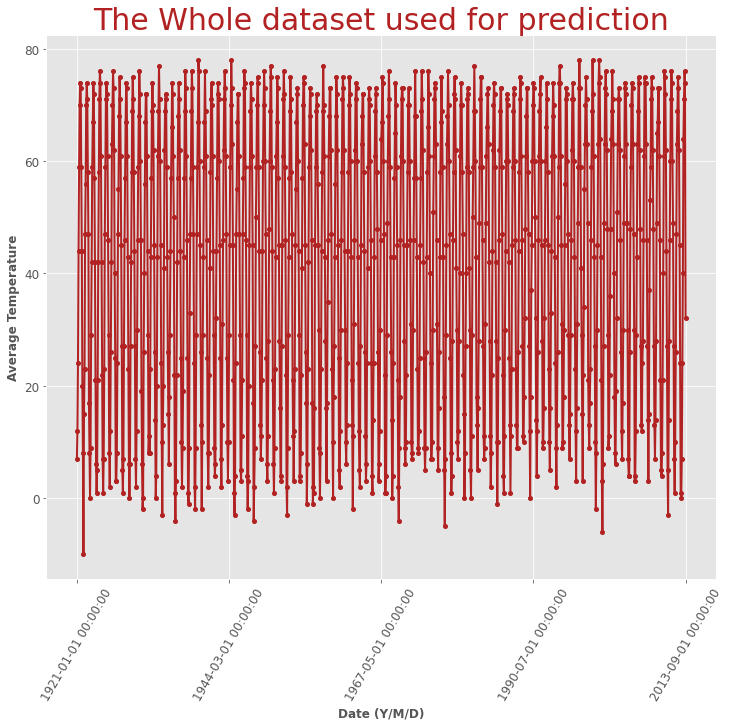

In [30]:
plt.title('The Whole dataset used for prediction', fontsize=30,color='firebrick')
plot_timeseries(1921,2013)

In [34]:
temp = get_timeseries(1921,2013)
N = len(temp.averagetemperature_f)
split = 0.95
training_size = round(split*N)
test_size = round((1-split)*N)
series = temp.averagetemperature_f[:training_size]
date = temp.dt[:training_size]
test_series = temp.averagetemperature_f[len(date)-1:len(temp)]
test_date = temp.dt[len(date)-1:len(temp)]
test_date = test_date.reset_index().dt
test_series = test_series.reset_index().averagetemperature_f

In [35]:
test_date

0    2009-01-01
1    2009-02-01
2    2009-03-01
3    2009-04-01
4    2009-05-01
5    2009-06-01
6    2009-07-01
7    2009-08-01
8    2009-09-01
9    2009-10-01
10   2009-11-01
11   2009-12-01
12   2010-01-01
13   2010-02-01
14   2010-03-01
15   2010-04-01
16   2010-05-01
17   2010-06-01
18   2010-07-01
19   2010-08-01
20   2010-09-01
21   2010-10-01
22   2010-11-01
23   2010-12-01
24   2011-01-01
25   2011-02-01
26   2011-03-01
27   2011-04-01
28   2011-05-01
29   2011-06-01
30   2011-07-01
31   2011-08-01
32   2011-09-01
33   2011-10-01
34   2011-11-01
35   2011-12-01
36   2012-01-01
37   2012-02-01
38   2012-03-01
39   2012-04-01
40   2012-05-01
41   2012-06-01
42   2012-07-01
43   2012-08-01
44   2012-09-01
45   2012-10-01
46   2012-11-01
47   2012-12-01
48   2013-01-01
49   2013-02-01
50   2013-03-01
51   2013-04-01
52   2013-05-01
53   2013-06-01
54   2013-07-01
55   2013-08-01
56   2013-09-01
Name: dt, dtype: datetime64[ns]

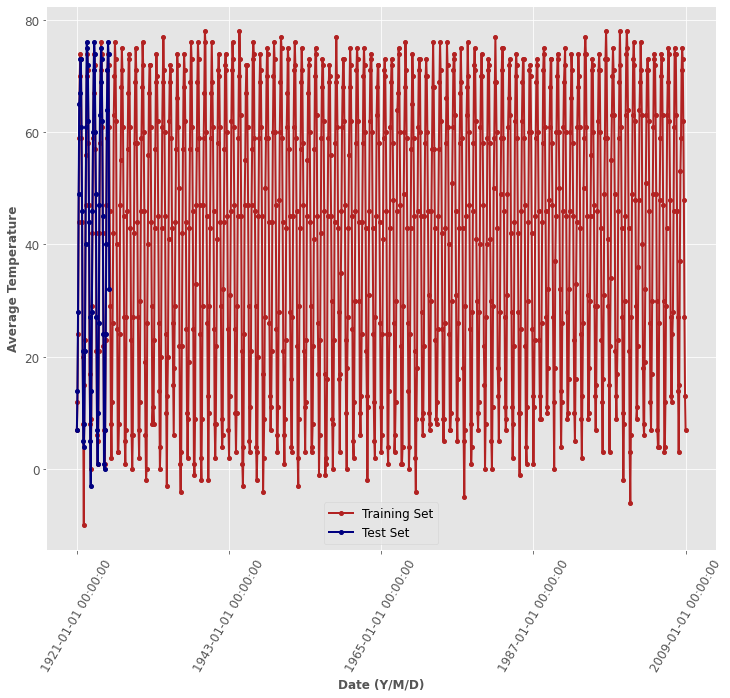

In [36]:
plot_from_data(series,date,label='Training Set')
plot_from_data(test_series,test_date,'navy',with_ticks=False,label='Test Set')
plt.legend()

# Finding the optimal parameters

In [37]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        #try: 
        model = SARIMAX(exog, order=order).fit(disp=-1)
    #except:
    #        continue
            
        aic = model.aic
        results.append([order, model.aic])
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [38]:
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = series)


C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fa

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

In [39]:
result_d_0.head()

,"(p, d, q)",AIC
0,"(9, 0, 8)",5403.593527
1,"(8, 0, 9)",5416.370154
2,"(6, 0, 9)",5421.109417
3,"(8, 0, 8)",5443.746736
4,"(6, 0, 7)",5444.607892


In [40]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = series)

result_d_1

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fa

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

,"(p, d, q)",AIC
0,"(7, 1, 9)",5399.281600
1,"(5, 1, 7)",5407.036644
2,"(8, 1, 8)",5407.061459
3,"(9, 1, 9)",5412.221234
4,"(9, 1, 8)",5418.077107
5,"(7, 1, 7)",5418.240308
6,"(6, 1, 9)",5424.194424
7,"(6, 1, 8)",5427.348623
8,"(7, 1, 8)",5428.541354
9,"(6, 1, 7)",5431.286026


In [41]:
result_d_1.head()

,"(p, d, q)",AIC
0,"(7, 1, 9)",5399.281600
1,"(5, 1, 7)",5407.036644
2,"(8, 1, 8)",5407.061459
3,"(9, 1, 9)",5412.221234
4,"(9, 1, 8)",5418.077107


In [42]:
final_result = result_d_0.append(result_d_1)

In [43]:
best_models = final_result.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()

In [44]:
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]

In [45]:
best_model_0 = SARIMAX(series, order=best_model_params_0).fit()
print(best_model_0.summary())
best_model_1 = SARIMAX(series, order=best_model_params_1).fit()
print(best_model_1.summary())

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                SARIMAX Results                                 
Dep. Variable:     averagetemperature_f   No. Observations:                 1057
Model:                 SARIMAX(7, 1, 9)   Log Likelihood               -2682.641
Date:                  Wed, 17 Nov 2021   AIC                           5399.282
Time:                          11:11:23   BIC                           5483.640
Sample:                               0   HQIC                          5431.259
                                 - 1057                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3656      0.103      3.535      0.000       0.163       0.568
ar.L2          0.4495      0.131      3.427      0.001       0.192       0.707
ar.L3         -0.7267      0.078    

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


# Model (2,1,5) results:

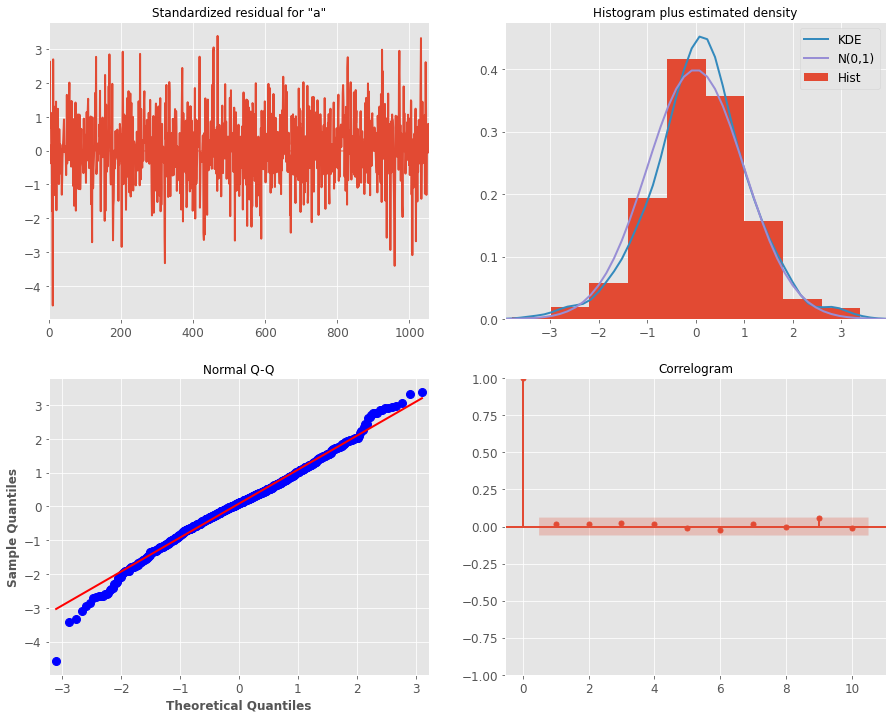

In [46]:
best_model_0.plot_diagnostics(figsize=(15,12))
plt.show()

# Model (2,1,6) results:

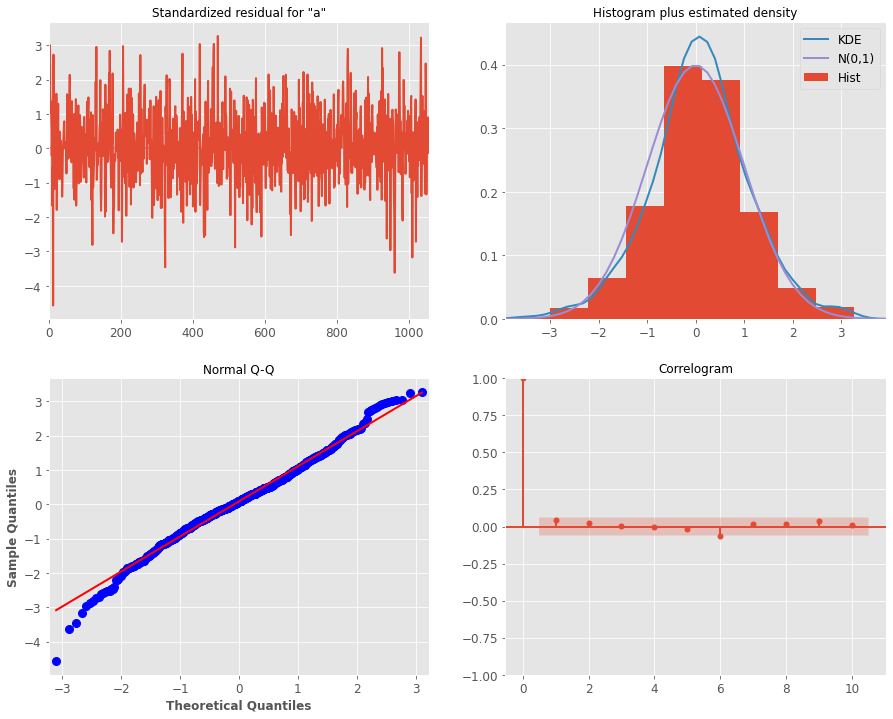

In [47]:
best_model_1.plot_diagnostics(figsize=(15,12))
plt.show()

## Forecasting

In [48]:
fore_l= test_size-1
forecast = best_model_0.get_prediction(start=training_size, end=training_size+fore_l)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

s_forecast = best_model_1.get_prediction(start=training_size, end=training_size+fore_l)
s_forec = s_forecast.predicted_mean
s_ci = forecast.conf_int(alpha=0.05)

In [50]:

error_test=city_data.loc[test_date[1:].index.tolist()].averagetemperatureuncertainty
index_test = test_date[1:].index.tolist()
test_set = test_series[1:]

In [51]:
lower_test = test_set-error_test
upper_test = test_set+error_test

In [79]:
print(forec)

1057    14.294303
1058    30.011115
1059    47.697259
1060    61.725496
1061    70.859631
1062    73.976212
1063    71.991652
1064    61.938668
1065    45.542059
1066    26.015517
1067    10.801344
1068     6.355135
1069    14.114337
1070    29.884326
1071    47.763272
1072    61.688204
1073    70.793134
1074    74.238390
1075    71.689667
1076    62.087379
1077    45.409161
1078    25.972978
1079    11.010572
1080     6.305914
1081    14.145150
1082    29.945778
1083    47.524394
1084    61.879809
1085    70.717795
1086    74.261016
1087    71.770898
1088    61.883895
1089    45.446821
1090    26.001257
1091    10.970371
1092     6.532658
1093    14.026847
1094    29.946682
1095    47.532169
1096    61.760279
1097    70.868509
1098    74.240835
1099    71.704460
1100    61.929942
1101    45.272345
1102    26.094354
1103    11.044211
1104     6.523017
1105    14.146688
1106    29.824037
1107    47.497935
1108    61.818608
1109    70.802675
1110    74.359935
1111    71.644045
1112    61

In [53]:
s_forec

1057    14.625596
1058    30.231770
1059    47.973358
1060    61.806848
1061    70.980689
1062    74.461496
1063    72.269692
1064    62.236771
1065    45.432385
1066    25.574112
1067    10.594576
1068     6.250998
1069    14.371242
1070    30.287599
1071    47.875164
1072    61.874557
1073    70.915908
1074    74.527820
1075    72.208957
1076    62.264908
1077    45.357691
1078    25.604964
1079    10.560717
1080     6.313452
1081    14.353693
1082    30.322676
1083    47.838590
1084    61.893675
1085    70.896267
1086    74.555117
1087    72.181936
1088    62.263098
1089    45.310994
1090    25.608605
1091    10.553995
1092     6.349311
1093    14.360889
1094    30.335805
1095    47.820565
1096    61.897584
1097    70.889664
1098    74.570204
1099    72.167188
1100    62.248335
1101    45.277613
1102    25.599672
1103    10.558331
1104     6.376227
1105    14.374782
1106    30.343604
1107    47.807502
1108    61.896207
1109    70.889233
1110    74.578432
1111    72.159091
1112    62

# Plotting Our Predictions
#### Prediction 1

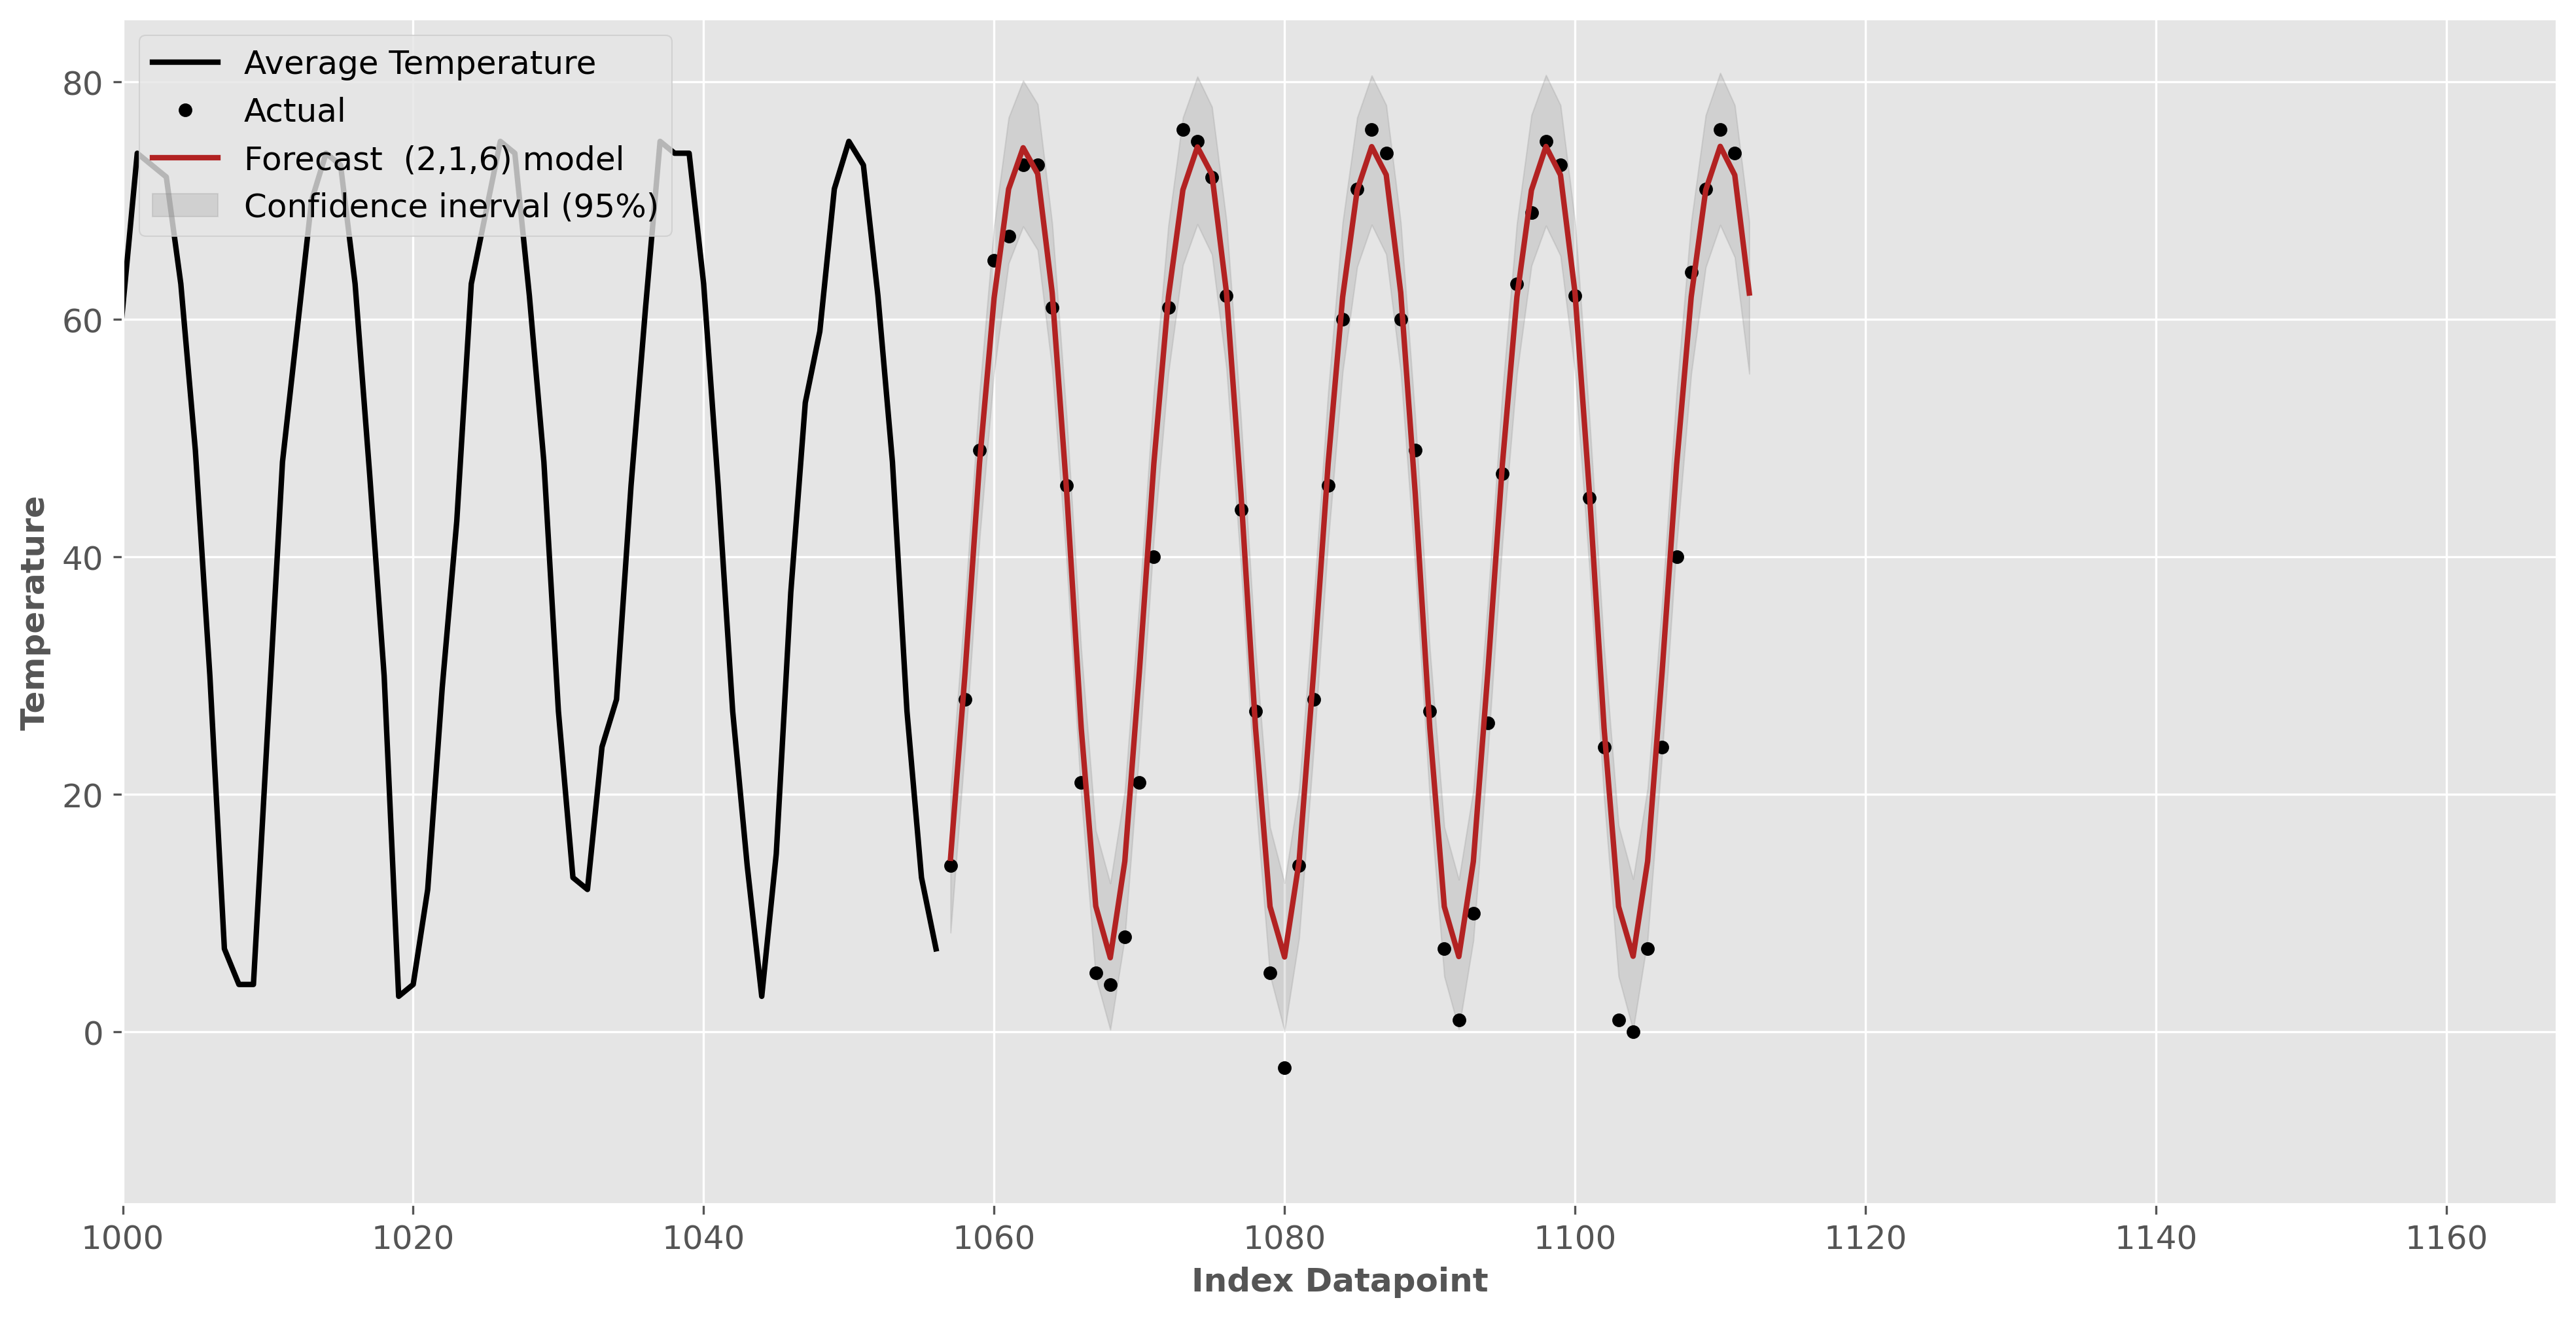

In [60]:
fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = city_data.averagetemperature_f.index[0:training_size]
x1=city_data.averagetemperature_f.index[training_size:training_size+fore_l+1]
plt.plot(x0, city_data.averagetemperature_f[0:training_size],'k', label = 'Average Temperature')
plt.plot(city_data.averagetemperature_f[training_size:training_size+fore_l], '.k', label = 'Actual')
#forec.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
#ax.fill_between(x1, ci['lower averagetemperature_f'], ci['upper averagetemperature_f'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

s_forec.plot(ax=ax,color = 'firebrick',label = 'Forecast  (2,1,6) model')
ax.fill_between(x1, s_ci['lower averagetemperature_f'], s_ci['upper averagetemperature_f'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.xlim(1000,)
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

# Plotting Our Predictions
#### Prediction 2

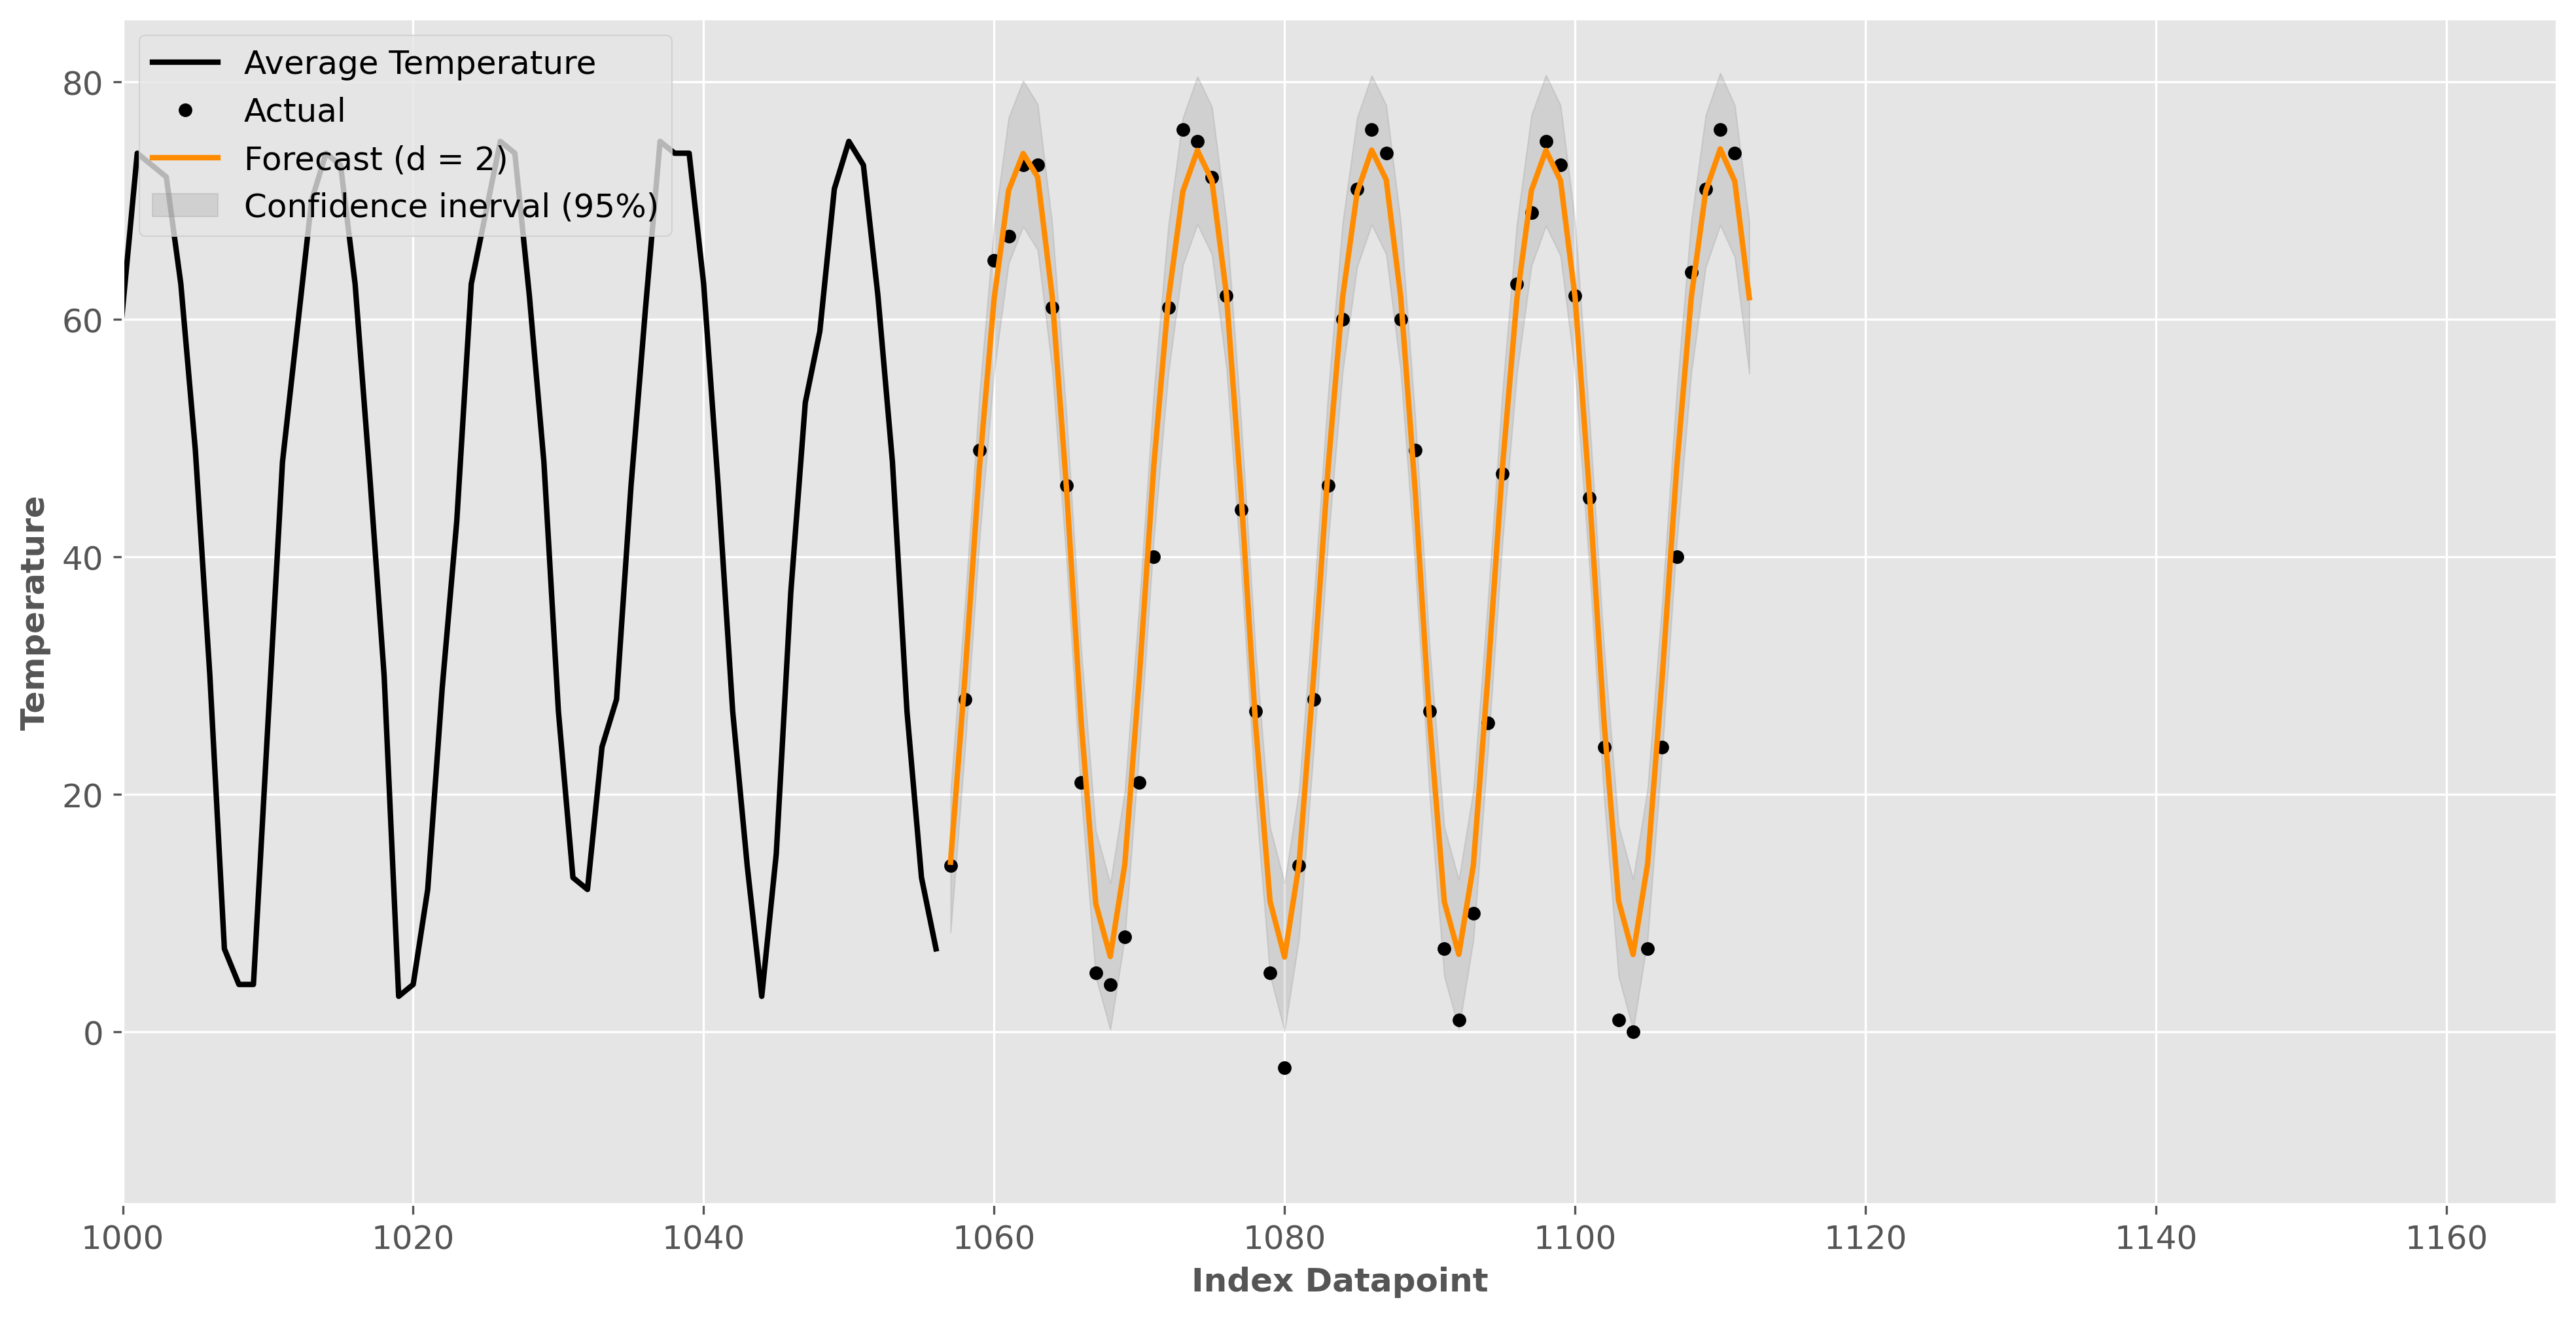

In [61]:
fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = city_data.averagetemperature_f.index[0:training_size]
x1=city_data.averagetemperature_f.index[training_size:training_size+fore_l+1]
plt.plot(x0, city_data.averagetemperature_f[0:training_size],'k', label = 'Average Temperature')
plt.plot(city_data.averagetemperature_f[training_size:training_size+fore_l], '.k', label = 'Actual')
forec.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
ax.fill_between(x1, ci['lower averagetemperature_f'], ci['upper averagetemperature_f'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

# s_forec.plot(ax=ax,color = 'firebrick',label = 'Forecast  (2,1,6) model')
# ax.fill_between(x1, s_ci['lower averagetemperature_f'], s_ci['upper averagetemperature_f'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.xlim(1000,)
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

# Prediction Comparison

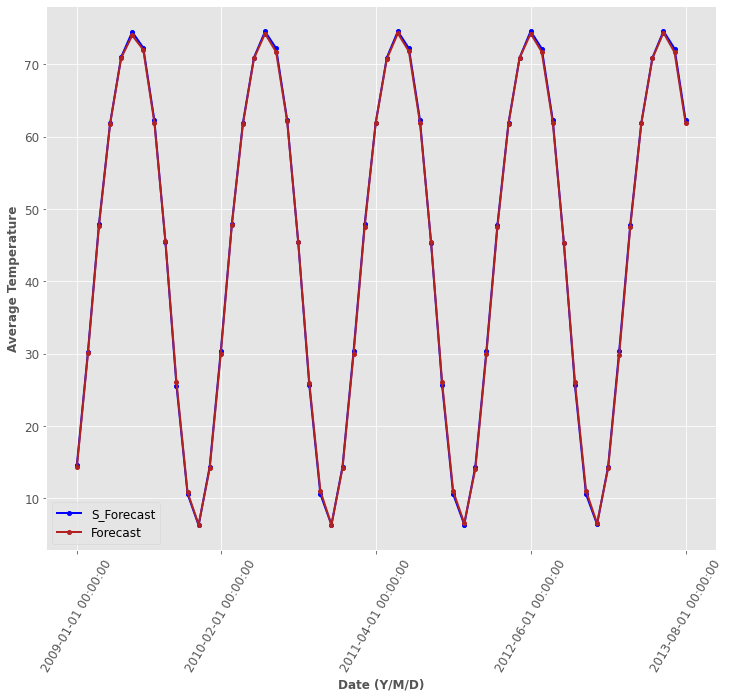

In [62]:
plot_from_data(s_forec,test_date,c='blue',label='S_Forecast')
plot_from_data(forec,test_date,c='firebrick',label='Forecast')
plt.legend(loc=3)

# Prediction 1 Vs Actual

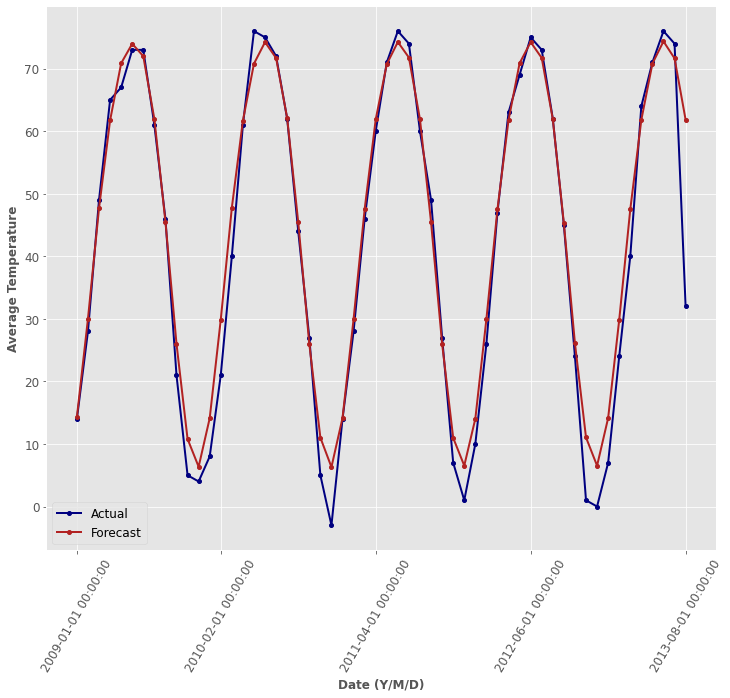

In [63]:
plot_from_data(test_set,test_date,c='navy',label='Actual')
plot_from_data(forec,test_date,c='firebrick',label='Forecast')
plt.legend(loc=3)

# Prediction 2 Vs Actual

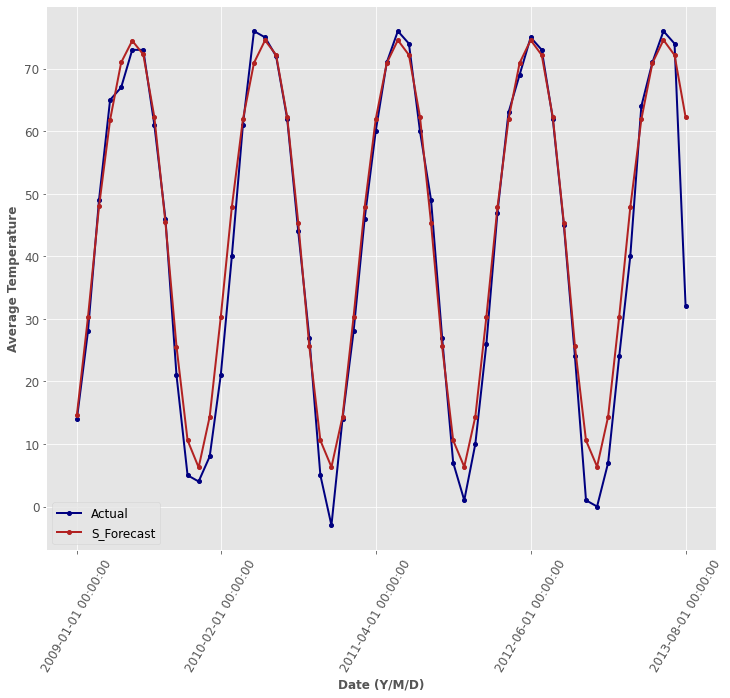

In [64]:
plot_from_data(test_set,test_date,c='navy',label='Actual')
plot_from_data(s_forec,test_date,c='firebrick',label='S_Forecast')
plt.legend(loc=3)

# Recreating DataFrame

In [65]:
df = pd.DataFrame(forec)
df.head()

,predicted_mean
1057,14.294303
1058,30.011115
1059,47.697259
1060,61.725496
1061,70.859631


In [66]:
df["s_forec"] = list(s_forec)


In [67]:
df= df.rename(columns={"predicted_mean": "forec"})

In [68]:
df["average_predicted"] = (df.forec + df.s_forec) / 2


In [69]:
df["City"] = city
df.head()

,forec,s_forec,average_predicted,City
1057,14.294303,14.625596,14.459949,Changchun
1058,30.011115,30.231770,30.121442,Changchun
1059,47.697259,47.973358,47.835309,Changchun
1060,61.725496,61.806848,61.766172,Changchun
1061,70.859631,70.980689,70.920160,Changchun


In [70]:
dt_df = pd.DataFrame(test_date)
dt_df.tail()

,dt
52,2013-05-01
53,2013-06-01
54,2013-07-01
55,2013-08-01
56,2013-09-01


In [71]:
test_dates = dt_df.dt.values


In [72]:
test_dates = test_dates[0:-1]

In [73]:
df["dt"] = test_dates
df.head()

,forec,s_forec,average_predicted,City,dt
1057,14.294303,14.625596,14.459949,Changchun,2009-01-01
1058,30.011115,30.231770,30.121442,Changchun,2009-02-01
1059,47.697259,47.973358,47.835309,Changchun,2009-03-01
1060,61.725496,61.806848,61.766172,Changchun,2009-04-01
1061,70.859631,70.980689,70.920160,Changchun,2009-05-01


In [74]:
df["AverageTemperature"] = list(test_set)

In [75]:
df= df[['dt','City','AverageTemperature','forec', 's_forec']]


# Join Tables Together

In [77]:
df_final = df_final.append(df)

In [18]:
df_final

,Unnamed: 0,dt,City,forec,s_forec,AverageTemperature
0,1060,4/1/2009,Changchun,62.293113,61.639845,61.966479
1,1061,5/1/2009,Changchun,71.278829,70.265702,70.772266
2,1062,6/1/2009,Changchun,74.495841,73.680999,74.088420
3,1063,7/1/2009,Changchun,72.240808,71.532836,71.886822
4,1064,8/1/2009,Changchun,62.234833,61.715885,61.975359
...,...,...,...,...,...,...
5070,2070,6/1/2093,Saint Petersburg,59.870319,59.870319,59.870319
5071,2071,7/1/2093,Saint Petersburg,58.863173,58.863173,58.863173
5072,2072,8/1/2093,Saint Petersburg,52.831609,52.831609,52.831609
5073,2073,9/1/2093,Saint Petersburg,43.392023,43.392023,43.392023


# Find Number of Average Temps <= 32

In [19]:
df_final = df_final[df_final["AverageTemperature"] <= 32]
df_final['City'].value_counts()

Changchun           421
Harbin              421
Moscow              382
Montreal            338
Saint Petersburg    336
Name: City, dtype: int64

In [32]:
df_final= df_final.rename(columns={"City":"city"})

# Send Combined Table to Database

In [47]:
# copy_to_db(connect(param_dic), df_final,"final_data")

Connecting to the PostgreSQL database...
Connection Successful!
Done!


In [48]:
# execute_query(connect(param_dic), 
# """              
# CREATE TABLE final_data (
#     id INT NOT NULL,
#      dt DATE NOT NULL,
#     city VARCHAR (50) NOT NULL,
#     forec decimal (5,0),
#     s_forec decimal (5,0),
#     averagetemperature decimal (5,0)
# );""")
open_as_df("SELECT * FROM final_data;",connect(param_dic))
# execute_query(connect(param_dic), "DROP TABLE ")

Connecting to the PostgreSQL database...
Connection Successful!


,id,dt,city,forec,s_forec,averagetemperature
0,1066,2009-10-01,Changchun,26.0,26.0,26.0
1,1067,2009-11-01,Changchun,11.0,11.0,11.0
2,1068,2009-12-01,Changchun,6.0,6.0,6.0
3,1069,2010-01-01,Changchun,14.0,14.0,14.0
4,1070,2010-02-01,Changchun,30.0,29.0,30.0
...,...,...,...,...,...,...
1893,2054,2092-02-01,Saint Petersburg,27.0,27.0,27.0
1894,2063,2092-11-01,Saint Petersburg,25.0,25.0,25.0
1895,2064,2092-12-01,Saint Petersburg,20.0,20.0,20.0
1896,2065,2093-01-01,Saint Petersburg,21.0,21.0,21.0


In [51]:
# copy_table_schema("final_data","practice_table")

C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:72: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
C:\Users\trevo\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:80: SADeprecationWarning: The Column.copy() method is deprecated and will be removed in a future release. (deprecated since: 1.4)


In [55]:
open_as_df("SELECT * FROM final_data",connect(param_dic))

Connecting to the PostgreSQL database...
Connection Successful!


,id,dt,city,forec,s_forec,averagetemperature,key
0,1060,2009-04-01,Changchun,62.0,62.0,62.0,1
1,1061,2009-05-01,Changchun,71.0,70.0,71.0,2
2,1062,2009-06-01,Changchun,74.0,74.0,74.0,3
3,1063,2009-07-01,Changchun,72.0,72.0,72.0,4
4,1064,2009-08-01,Changchun,62.0,62.0,62.0,5
...,...,...,...,...,...,...,...
5070,2070,2093-06-01,Saint Petersburg,60.0,60.0,60.0,5071
5071,2071,2093-07-01,Saint Petersburg,59.0,59.0,59.0,5072
5072,2072,2093-08-01,Saint Petersburg,53.0,53.0,53.0,5073
5073,2073,2093-09-01,Saint Petersburg,43.0,43.0,43.0,5074


In [54]:
execute_query(connect(param_dic),"""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")

Connecting to the PostgreSQL database...
Connection Successful!


[('ave_cost_cold_cities',),
 ('practice_table',),
 ('final_data',),
 ('changchun',),
 ('harbin',),
 ('moscow',),
 ('st_petersburg',),
 ('montreal',),
 ('clean_cities',),
 ('cold_cities',),
 ('ave_cost',)]